In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
import re
import plotly.figure_factory as ff
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNetCV, LassoCV, RidgeCV, HuberRegressor, RANSACRegressor, TheilSenRegressor, SGDRegressor
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [4]:
df = pd.read_csv('listings.csv')

In [11]:
df.sample(10)

,title,listing_type,city,zip_code,numerical_descriptors,amenities,dates,rating,num_reviews,discounted,original_value,price_per_night,cleaning_fee,service_fee
7194,"Queen Anne Hotel, Victorian King",room in boutique hotel,Western Addition/NOPA,94133,2 guests - 1 bedroom - 1 bed - 1 private bath,Wifi,Dec 3 – 5,4.45,22,False,NaN,179.0,0.0,0.0
919,Dorm Bed In Friendly Hostel Community #13,hostel beds,Financial District,94104,3 guests - 1 bedroom - 8 beds - 1 shared bath,Wifi - Kitchen - Washer,Dec 24 – 26,4.70,102,False,NaN,53.0,0.0,0.0
12400,Sunny enclosed backyard in quiet St w easy par...,entire rental unit,Paradise Park,94649,6 guests - 3 bedrooms - 3 beds - 2 baths,Wifi - Kitchen - Free parking - Washer,Dec 24 – 26,4.50,4,False,NaN,300.0,120.0,102.0
19524,Private room &bath /shared driveway,private room,Daly City,94044,1 guest - 1 bedroom - 1 bed - 1 private bath,Wifi - Free parking,Dec 17 – 19,NaN,0,True,74.0,38.0,40.0,0.0
19734,Affordable 1Bed/1Bath w/ Separated Living Room,entire rental unit,South San Francisco,94066,2 guests - 1 bedroom - 1 bed - 1 bath,Wifi - Washer,Dec 31 – Jan 2,4.26,39,False,NaN,69.0,60.0,28.0
2498,Private Guest Suite with Private Bathroom and ...,private room,Portola,94110,3 guests - 1 private bedroom - 3 beds - 1 priv...,Wifi - Self check-in,Dec 17 – 19,4.85,172,False,NaN,129.0,59.0,45.0
9890,Charming 2 Bedroom Apartment,entire rental unit,Dogtown,94609,4 guests - 2 bedrooms - 2 beds - 1 bath,Wifi - Kitchen - Washer,Dec 3 – 5,4.78,73,False,NaN,144.0,120.0,58.0
11640,Cottage in Temescal,entire rental unit,Shafter,94619,2 guests - 1 bedroom - 1 bed - 1 bath,Wifi - Kitchen,Dec 24 – 26,4.84,55,False,NaN,130.0,100.0,51.0
1873,Awesome location in Union Square at THE DONATELLO,hotel room,Downtown,94108,4 guests - Studio - 2 beds - 1 private bath,Wifi - Self check-in,Dec 24 – 26,5.00,7,False,NaN,374.0,0.0,106.0
4675,Quiet Getaway. Centrally located in Inner Rich...,private room,Richmond District,94121,2 guests - 1 bedroom - 1 bed - 1 bath,Wifi - Kitchen,Dec 24 – 26,NaN,0,False,NaN,62.0,75.0,28.0


In [3]:
# Since zip_code was from our query and not pulled from
# AirBnB itself, we'll need to drop it as it won't give us
# accurate insights or information.
df.drop('zip_code', axis = 1, inplace = True)

In [4]:
# Drop duplicates - after going through our data, it looks like the date does not have a strong correlation so we will drop those duplicates as well
df.drop_duplicates(['title', 'listing_type', 'city',
                   'numerical_descriptors', 'amenities'],
                   inplace = True)
df.reset_index(drop = True, inplace = True)

In [5]:
# orig_price = list(df[df['discounted'] == 1].index)
# df.loc[orig_price, 'price_per_night'] = df.loc[orig_price, 'original_value']

In [6]:
# Drop some columns that we determined as insignificant as well as some text based columns
df.drop(['title', 'num_reviews', 'rating', 'dates'], axis = 1, inplace = True)
df = df.reset_index(drop = True)

# Some simple cleaning and adjustments
df = df.rename({"city": "area"}, axis = 1)
df['discounted'] = df['discounted'].astype(int)

In [7]:
# Create dummies for area and listing_type - drop the first columns
areas = pd.get_dummies(df['area'], drop_first = True)
# dates = pd.get_dummies(df['dates'], drop_first = True)
listing_types = pd.get_dummies(df['listing_type'], drop_first = True)
df.drop(['area', 'listing_type'], axis = 1, inplace = True)

In [8]:
# Concatenate the 3 dfs
df = pd.concat([df, areas, listing_types], axis = 1)

In [9]:
# Convert the amenities into a list so we can use MLB
def str_to_list(amenities_str):
    if amenities_str == 'None':
        return []
    else:
        return amenities_str.strip().split(' - ')
    
df['amenities'] = df['amenities'].fillna('None')
df['amenities'] = df['amenities'].apply(str_to_list)

# Use MultiLabelBinarizer from scikit to encode
mlb = MultiLabelBinarizer()
amenities_df = pd.DataFrame(mlb.fit_transform(df['amenities']), columns = mlb.classes_)

# Concatenate the df with amenities and drop the amenities column
df.drop('amenities', axis = 1, inplace = True)
df = pd.concat([df, amenities_df], axis = 1)

In [10]:
def guest_num(nd_list):
    for nd_str in nd_list:
        if 'guest' in str.lower(nd_str):
            guest_n = nd_str
            nd_list.remove(nd_str)
            return guest_n
    return 'N/A guest'

def bedroom_num(nd_list):
    for nd_str in nd_list:
        if 'bedroom' in str.lower(nd_str):
            bedroom_n = nd_str
            nd_list.remove(nd_str)
            return nd_str
        elif 'studio' in str.lower(nd_str):
            studio = nd_str
            nd_list.remove(nd_str)
            return nd_str
    return 'N/A bedroom'

def bed_num(nd_list):
    for nd_str in nd_list:
        if 'bed' in str.lower(nd_str):
            bed_n = nd_str
            nd_list.remove(nd_str)
            return nd_str
    return 'N/A bed'

def sharedbath_num(nd_list):
    for nd_str in nd_list:
        if 'shared bath' in str.lower(nd_str):
            sbath_n = nd_str
            nd_list.remove(nd_str)
            return nd_str
    return 'N/A shared bath'

def bath_num(nd_list):
    for nd_str in nd_list:
        if 'bath' in str.lower(nd_str):
            bath_n = nd_str
            nd_list.remove(nd_str)
            return nd_str
    return 'N/A bath'

In [11]:
df['numerical_descriptors'] = df['numerical_descriptors'].apply(str_to_list)

df['guests'] = df['numerical_descriptors'].apply(guest_num)
df['bedrooms'] = df['numerical_descriptors'].apply(bedroom_num)
df['beds'] = df['numerical_descriptors'].apply(bed_num)
df['shared baths'] = df['numerical_descriptors'].apply(sharedbath_num)
df['baths'] = df['numerical_descriptors'].apply(bath_num)


In [12]:
guest_dummies = pd.get_dummies(df['guests'], drop_first = True)
bedroom_dummies = pd.get_dummies(df['bedrooms'], drop_first = True)
bed_dummies = pd.get_dummies(df['beds'], drop_first = True)
sbath_dummies = pd.get_dummies(df['shared baths'], drop_first = True)
bath_dummies = pd.get_dummies(df['baths'], drop_first = True)

df = pd.concat([df, guest_dummies, bedroom_dummies, bed_dummies, sbath_dummies, bath_dummies], axis = 1)
df.drop(['numerical_descriptors', 'guests', 'bedrooms', 'beds', 'shared baths', 'baths'], axis = 1, inplace = True)

In [13]:
# If not discounted, fill in original_value with current price
df['original_value'] = df['original_value'].fillna(df['price_per_night'])

# If we look up how fees are calculated, we find out that the service fee is automatic.
# It is determined by AirBnB itself and has a formula:
# .14 * (n * p + c)
# where n is the number of nights
# p is the price per night
# c is the cleaning fee

# When putting up a listing or getting an idea of a listing, service fee does not come into play
# If I'm a host, I wouldn't know the service fee before putting my listing up
# If I'm a guest, I wouldn't use service fee as a parameter (neither would I use cleaning fee)

df.drop(['service_fee', 'cleaning_fee'], axis = 1, inplace = True)

df.drop(['original_value'], axis = 1, inplace = True)

In [14]:
# # To avoid data leakage, we need to split our dataframe before we impute missing values
# X = df.drop('price_per_night', axis = 1)
# y = df['price_per_night']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)

# df_train = pd.concat([X_train, y_train], axis = 1)
# df_test = pd.concat([X_test, y_test], axis = 1)

In [15]:
# # Declare our alphas and l1 ratios for elastic net later
# alphas = 10**np.linspace(-2, 2, 200)
# l1_ratios = np.array([.1, .5, .7, .9, .95, .99, 1])
# msfee = set(df_train[df_train['service_fee'] == 0].index)
# mcfee = set(df_train[df_train['cleaning_fee'] == 0].index)

# msfee_test = set(df_test[df_test['service_fee'] == 0].index)
# mcfee_test = set(df_test[df_test['cleaning_fee'] == 0].index)

In [16]:

# Impute ratings
# mratings = set(df[df['rating'].isna()].index)

# mratingsp = set()

# for i in msfee:
#     if i not in mratings:
#         mratingsp.add(i)
# for i in mcfee:
#     if i not in mratings:
#         mratingsp.add(i)
        
# mratingsp = list(mratingsp)

# dfr_train = df.drop(mratings)
# dfr_test = df.loc[mratings]

# dfr_train.drop(mratingsp, inplace = True)

# Xr_train = dfr_train.drop('rating', axis = 1)
# Xr_test = dfr_test.drop('rating', axis = 1)

# yr_train = dfr_train['rating']

# std = StandardScaler()
# std.fit(Xr_train.values)

# Xr_tr = std.transform(Xr_train.values)
# Xr_te = std.transform(Xr_test.values)

# mratings_model = LinearRegression()#alphas = alphas, l1_ratio = l1_ratios, cv = 5)
# mratings_model.fit(Xr_tr, yr_train)

# df.loc[mratings, 'rating'] = mratings_model.predict(Xr_te)

In [17]:
# # Impute service fees
# msp = []

# for i in mcfee:
#     if i not in msfee:
#         msp.append(i)
        
# dfs_train = df_train.drop(msfee)
# dfs_test = df_train.loc[msfee]

# dfs_train.drop(msp, inplace = True)

# Xs_train = dfs_train.drop('service_fee', axis = 1)
# Xs_test = dfs_test.drop('service_fee', axis = 1)

# ys_train = dfs_train['service_fee']

# std = StandardScaler()
# std.fit(Xs_train.values)

# Xs_tr = std.transform(Xs_train.values)
# Xs_te = std.transform(Xs_test.values)

# msfee_model = LinearRegression()#(alphas = alphas, l1_ratio = l1_ratios, cv = 5)
# msfee_model.fit(Xs_tr, ys_train)

# df_train.loc[msfee, 'service_fee'] = msfee_model.predict(Xs_te)

In [18]:
# # Impute cleaning fees
# mcp = []

# for i in msfee:
#     if i not in mcfee:
#         mcp.append(i)
        
# dfc_train = df_train.drop(mcfee)
# dfc_test = df_train.loc[mcfee]

# dfc_nantest = df_test.loc[mcfee_test]

# dfc_train.drop(mcp, inplace = True)

# Xc_train = dfc_train.drop('cleaning_fee', axis = 1)
# Xc_test = dfc_test.drop('cleaning_fee', axis = 1)

# yc_train = dfc_train['cleaning_fee']

# Xc_nantest = dfc_nantest.drop('cleaning_fee', axis = 1)

# std = StandardScaler()
# std.fit(Xc_train.values)

# Xc_tr = std.transform(Xc_train.values)
# Xc_te = std.transform(Xc_test.values)

# Xc_nante = std.transform(Xs_nantest.values)

# mcfee_model = LinearRegression()#alphas = alphas, l1_ratio = l1_ratios, cv = 5)
# mcfee_model.fit(Xc_tr, yc_train)

# df_train.loc[mcfee, 'cleaning_fee'] = mcfee_model.predict(Xc_te)
# df_test.loc[msfee_test, 'cleaning_fee'] = mcfee_model.predict(Xc_nante)

In [19]:
# # Subtract the imputed fees from the price_per_night
# df_train.loc[msfee, 'price_per_night'] -= df_train.loc[msfee, 'service_fee']/2
# df_train.loc[mcfee, 'price_per_night'] -= df_train.loc[mcfee, 'cleaning_fee']/2

# df_test.loc[msfee_test, 'price_per_night'] -= df_test.loc[msfee_test, 'service_fee']/2
# df_test.loc[mcfee_test, 'price_per_night'] -= df_test.loc[mcfee_test, 'service_fee']/2

In [20]:
# erroneous_train = list(df_train[df_train['price_per_night'] < 0].index)
# erroneous_test = list(df_test[df_test['price_per_night'] < 0].index)
# # erroneous += list(df[df['rating'] > 5].index)
# df_train.drop(erroneous_train, inplace = True)
# df_test.drop(erroneous_test, inplace = True)

In [14]:
random_state = np.random.randint(1634)

In [15]:
df.to_csv('adjlistings.csv', index = False)

***

***

***

In [16]:
X = df.drop('price_per_night', axis = 1)
y = df['price_per_night']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = random_state)
model = LinearRegression()
model_fit = model.fit(X_train, y_train)
print("R2_train:", model_fit.score(X_train, y_train))
print("R2_test:", model_fit.score(X_test, y_test))

X_trainsm, X_testsm = X_train.copy(), X_test.copy()
X_trainsm['constant'] = 1
X_testsm['constant'] = 1
modelsm = sm.OLS(y_train, X_trainsm)
modelsm_fit = modelsm.fit()
modelsm_fit.summary()

R2_train: 0.6152634511476734
R2_test: -1.1095172659697888e+20


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        price_per_night   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     14.18
Date:                Mon, 13 Dec 2021   Prob (F-statistic):               0.00
Time:                        15:46:15   Log-Likelihood:                -16748.
No. Observations:                2577   AIC:                         3.402e+04
Df Residuals:                    2315   BIC:                         3.555e+04
Df Model:                         261                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
discounted                   -57.9665     12.596     -4.602      0.000     -82.667     -33.266
Albany                        11.3923     58.325      0.195      0.845    -102.983     125.768
Atchison Village              51.2239    174.750      0.293      0.769    -291.458     393.906
Atherton                     -49.7826     88.817     -0.561      0.575    -223.951     124.386
Balboa Terrace                99.5931     89.262      1.116      0.265     -75.449     274.635
Bayview                       28.0038     42.271      0.662      0.508     -54.889     110.897
Belding/Woods                -40.5754     95.238     -0.426      0.670    -227.336     146.186
Belmont                       16.0005     43.366      0.369      0.712     -69.040     101.041
Belvedere Tiburon            426.4896    172.784      2.468      0.014      87.662     765.318
Berkeley                       5.6169     38.072      0.148      0.883     -69.041      80.275
Berkeley Hills                49.7997     49.208      1.012      0.312     -46.696     146.295
Bernal Heights                75.6565     39.698      1.906      0.057      -2.190     153.503
Brisbane                     212.3669     85.489      2.484      0.013      44.724     380.010
Burlingame                     9.7500     32.010      0.305      0.761     -53.020      72.520
Castro Valley                 -6.5772    126.251     -0.052      0.958    -254.154     240.999
Central Berkeley              31.1333     58.379      0.533      0.594     -83.348     145.615
Chinatown                    183.5176     39.344      4.664      0.000     106.364     260.671
Civic Center                 184.4236    182.333      1.011      0.312    -173.130     541.977
Clawson                       45.1141     68.920      0.655      0.513     -90.036     180.265
Clinton                       19.8117     74.106      0.267      0.789    -125.509     165.132
Cole Valley                  290.0002     91.518      3.169      0.002     110.534     469.467
Coronado                     -1.2e-13   6.77e-13     -0.177      0.859   -1.45e-12    1.21e-12
Corte Madera                 237.1571     60.144      3.943      0.000     119.216     355.098
Cow Hollow                   196.1359     50.393      3.892      0.000      97.316     294.956
Crocker Amazon               -34.9012     42.029     -0.830      0.406    -117.320      47.518
Daly City                     -5.6863     25.778     -0.221      0.825     -56.237      44.865
Dogpatch                     180.3771    172.303      1.047      0.295    -157.507     518.261
Dogtown                      -32.4492     53.700     -0.604      0.546    -137.754      72.855
Downtown                     170.2329     33.198      5.128      0.000     105.132     235.333
Downtown Berkeley             34.8118     8

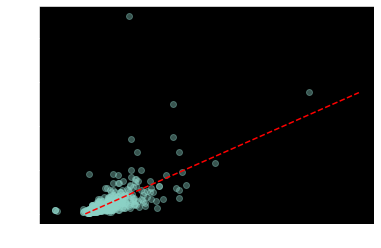

In [17]:
line = np.linspace(0,max(modelsm_fit.predict(X_testsm)) + 500,10001)
plt.scatter(modelsm_fit.predict(X_testsm), y_test, alpha = 0.4)
plt.plot(line, line, 'r--')

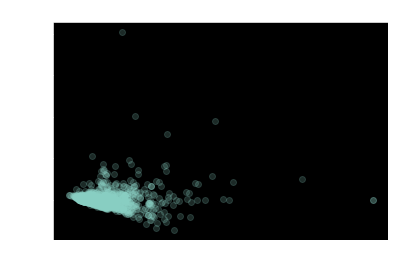

In [18]:
plt.scatter(modelsm_fit.predict(X_trainsm), modelsm_fit.resid, alpha = 0.2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

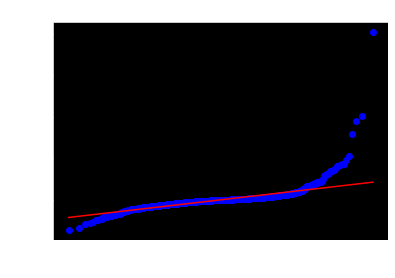

In [19]:
stats.probplot(modelsm_fit.resid, dist = 'norm', plot = plt)
plt.show()

# Summary

* Errors are not normally distributed - try transformations later on
* Many features seem to have a high p-value so we may need to drop those

***

***

***

# Model 2

Let's try removing any features with a p-value of greater than 0.05

In [20]:
drop_cols = list(modelsm_fit.pvalues[modelsm_fit.pvalues > 0.05].index)

if 'constant' in drop_cols:
    drop_cols.remove('constant')
dfadj = df.drop(drop_cols, axis = 1)

In [27]:
import warnings
from IPython.display import clear_output
warnings.filterwarnings("ignore")

dfadj2 = dfadj.copy()
while True:
    X = dfadj2.drop('price_per_night', axis = 1)
    y = dfadj2['price_per_night']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)
    model = LinearRegression()
    model_fit = model.fit(X_train, y_train)
    print("R2_train:", model_fit.score(X_train, y_train))
    print("R2_test:", model_fit.score(X_test, y_test))

    X_trainsm, X_testsm = X_train.copy(), X_test.copy()
    X_trainsm['constant'] = 1
    X_testsm['constant'] = 1
    modelsm = sm.OLS(y_train, X_trainsm)
    modelsm_fit = modelsm.fit()
    
    drop_cols = list(modelsm_fit.pvalues[modelsm_fit.pvalues > 0.05].index)
    vif = pd.DataFrame()
    vif['variables'] = X.columns
    vif['vif'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    drop_cols += list(vif[vif['vif'].apply(np.isinf)]['variables'])
    if 'constant' in drop_cols:
        drop_cols.remove('constant')
    
    print(drop_cols)
    dfadj2 = dfadj2.drop(drop_cols, axis = 1)
    
    if len(drop_cols) == 0:
        break

R2_train: 0.5747380300133098
R2_test: -2.511136423473052e+21
['Cow Hollow', 'Downtown Oakland', 'East Oakland', 'El Grenada', 'North Beach', 'Pacific Heights', 'Produce and Waterfront', 'Pullman', 'Richmond District', 'Telegraph Hill', 'entire apartment', 'entire bungalow', 'hotel beds', 'Free parking', '13 guests', 'Studio', 'Gas fireplace', 'Massage table', '19 bedrooms', '9 baths']
R2_train: 0.5413477042011363
R2_test: 0.43808940285225084
['Brisbane', 'Cole Valley', 'Potrero Hill', 'entire cabin', 'hut', '12 guests', '8 guests', '4 baths']
R2_train: 0.5208234966393275
R2_test: 0.4247564165847315
['Belvedere Tiburon', 'Kentfield', 'Mission Terrace', 'Muir Beach', 'SoMa', 'entire cottage', 'tiny house']
R2_train: 0.5439501664914752
R2_test: 0.35800968865507654
['Noe Valley', 'Tenderloin']
R2_train: 0.495971677250269
R2_test: 0.4696121221832136
['Corte Madera', 'Emeryville', 'entire residential home', 'hostel room', '5 bedrooms', '1.5 baths']
R2_train: 0.5022866995940044
R2_test: 0.490

In [28]:
modelsm_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        price_per_night   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     87.94
Date:                Mon, 13 Dec 2021   Prob (F-statistic):               0.00
Time:                        15:58:37   Log-Likelihood:                -16968.
No. Observations:                2577   AIC:                         3.401e+04
Df Residuals:                    2542   BIC:                         3.421e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
discounted               -59.1670     12.457     -4.750      0.000     -83.594     -34.740
Chinatown                151.9669     33.267      4.568      0.000      86.734     217.200
Downtown                 112.1072     22.151      5.061      0.000      68.672     155.542
Fisherman's Wharf        337.8563     43.032      7.851      0.000     253.475     422.238
Hillsborough             212.7120     88.648      2.400      0.016      38.882     386.542
Marina                   684.7318     45.503     15.048      0.000     595.505     773.958
Mill Valley              115.5919     29.028      3.982      0.000      58.671     172.513
Mission District          76.1670     27.244      2.796      0.005      22.744     129.590
Nob Hill                 105.5320     27.624      3.820      0.000      51.363     159.701
Pacifica                  64.3343     20.368      3.159      0.002      24.395     104.274
Stinson Beach            277.6120     67.083      4.138      0.000     146.068     409.156
The Castro               117.2461     34.891      3.360      0.001      48.829     185.663
Twin Peaks               190.2229     51.316      3.707      0.000      89.597     290.849
Western Addition/NOPA    150.7332     25.439      5.925      0.000     100.851     200.616
entire guest suite       -63.5892     13.212     -4.813      0.000     -89.497     -37.681
entire guesthouse        -75.4950     18.143     -4.161      0.000    -111.072     -39.918
entire rental unit       -63.8381     12.832     -4.975      0.000     -89.000     -38.676
entire vacation home   -6.761e-13    5.9e-14    -11.462      0.000   -7.92e-13    -5.6e-13
hostel beds             -176.1548     37.799     -4.660      0.000    -250.275    -102.035
private room            -126.6094     10.465    -12.098      0.000    -147.130    -106.088
room in boutique hotel   -45.2374     18.651     -2.425      0.015     -81.810      -8.664
shared room             -165.1201     22.670     -7.284      0.000    -209.574    -120.667
16 guests                375.2471     37.641      9.969      0.000     301.436     449.058
2 bedrooms                60.4205     11.765      5.136      0.000      37.350      83.491
2 private bedrooms       515.2901    182.010      2.831      0.005     158.387     872.193
3 bedrooms                93.4228     16.153      5.784      0.000      61.748     125.098
4 bedrooms               206.8573     27.329      7.569      0.000     153.268     260.446
6 bedrooms               631.7395     65.217      9.687      0.000     503.856     759.623
20 beds                 1537.7791    135.213     11.373      0.000    1272.640    1802.919
2 baths                  102.6733     14.841      6.918      0.000      73.571     131.775
2.5 baths                262.8093     34.138      7.698      0.000     195.868  

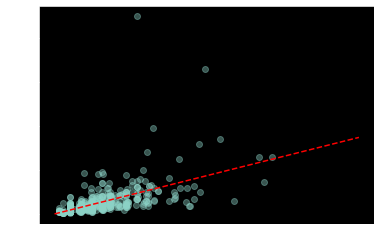

In [29]:
line = np.linspace(0,max(modelsm_fit.predict(X_testsm)) + 500,10001)
plt.scatter(modelsm_fit.predict(X_testsm), y_test, alpha = 0.4)
plt.plot(line, line, 'r--')

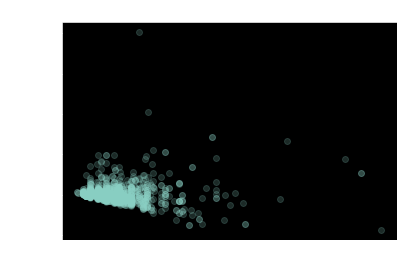

In [30]:
plt.scatter(modelsm_fit.predict(X_trainsm), modelsm_fit.resid, alpha = 0.2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

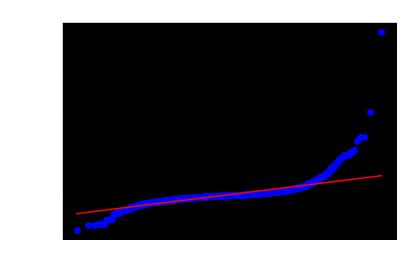

In [31]:
stats.probplot(modelsm_fit.resid, dist = 'norm', plot = plt)
plt.show()

In [32]:
df.to_csv('processed_listings.csv', index = False)

***

***

***